In [136]:
import numpy as np
import pandas as pd
import pickle
import random
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline



## Load in the feature data 

In [151]:
# patient suffixes for file names
mayo_suffs = ['001','002','003','004','005','006','007','008']
sans_suffs = ['01','02','03','04','05','06','07','08','09','10']
data_bypat = {} # holder for data seperated by patient

# loading the data from the pickle files
for s, suff in enumerate(sans_suffs):
    filename = 'feature_data/sansum-%s.p' % suff
    data_bypat['s%s' % (s+1)] = pickle.load(open(filename,'rb'))
    data_bypat['s%s' % (s+1)] = data_bypat['s%s' % (s+1)].fillna(data_bypat['s%s' % (s+1)].mean())
    
for m, suff in enumerate(mayo_suffs):
    filename = 'feature_data/mayo-%s.p' % suff
    data_bypat['m%s' % (m+1)] = pickle.load(open(filename,'rb'))
    data_bypat['m%s' % (m+1)] = data_bypat['m%s' % (m+1)].fillna(data_bypat['m%s' % (m+1)].mean())

## Train population KNN model 

In [152]:
data_bypat['m4'].describe()

,BG0,BG_PH,BGday_var,dBG30,dBG60,deda30,deda60,dtemp30,dtemp60,eda0,...,step0mean_2hr,step0mean_3hr,step0mean_4hr,step0mean_5hr,hr0adj_curr,hr0adj_mean_1hr,hr0adj_mean_2hr,hr0adj_mean_3hr,hr0adj_mean_4hr,hr0adj_mean_5hr
count,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,...,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000
mean,168.975459,168.136273,4144.643203,29.359737,29.359737,0.728818,0.728818,1.428518,1.428518,0.663621,...,2.355501,2.365646,2.313002,2.272165,1.090646,1.081850,1.071915,1.068315,1.074424,1.079914
std,68.674981,67.501925,1806.688218,41.287753,41.287753,2.718852,2.718852,2.693323,2.693323,2.284345,...,1.567256,1.556282,1.532710,1.507409,0.328553,0.295947,0.282024,0.274885,0.277110,0.272830
min,41.000000,41.000000,914.188695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024203,...,0.006772,0.006766,0.006766,0.006766,0.367577,0.346920,0.289476,0.292329,0.288533,0.321500
25%,115.000000,115.000000,2820.617412,0.000000,0.000000,0.000362,0.000362,0.102608,0.102608,0.076550,...,1.353368,1.448789,1.462878,1.484039,0.909362,0.926392,0.926827,0.935522,0.948014,0.955167
50%,159.000000,158.000000,4225.652181,13.000000,13.000000,0.078634,0.078634,0.615567,0.615567,0.181563,...,2.355501,2.365646,2.313002,2.272165,1.025945,1.032746,1.042131,1.055864,1.074424,1.079914
75%,216.000000,215.000000,5065.793871,41.000000,41.000000,0.594006,0.594006,1.452875,1.452875,0.407841,...,3.224366,3.103211,2.954139,2.791104,1.188396,1.155733,1.129262,1.110600,1.104015,1.101362
max,400.000000,400.000000,10225.061112,346.000000,346.000000,47.825802,47.825802,16.714900,16.714900,50.569796,...,11.464080,11.464080,11.464080,11.464080,2.719229,2.130433,2.235237,2.290072,2.306412,2.294515


In [6]:
# Generate 9 folds with random pairs of patients for cross validation
def get_folds(data):
    keynames = list(data.keys()) # get the key names that represent individual patients
    random.shuffle(keynames) # shuffle them into a random order
    folds = np.reshape(keynames, [9,2]) # pair them off into 9 folds
    return folds

In [124]:
## intakes training and test predictors, then scales them all down to be 0 mean and 1 variance (according to what is observed in training set)

def scale_data(xtrain,xtest):
    scaler = StandardScaler() # generate scaler
    xtrain.loc[:,:] = scaler.fit_transform(xtrain) # fit and transform on training
    xtest.loc[:,:] = scaler.transform(xtest) # naively transform test data without fitting to it
    return xtrain, xtest, scaler

In [122]:
### takes in the by patient data and the folds by which to seperate, outputs training features/labels and testing features/labels for the current fold being tested 
def get_train_test(data,folds,current_fold):
    ## get the test data
    
    # extract patients in current fold for testing
    test_data1 = data[folds[current_fold,0]]
    test_data2 = data[folds[current_fold,1]]
    # combine into one testing df
    test_data = pd.concat([test_data1,test_data2],ignore_index=True)
    # split into predictors and labels
    test_y = test_data['BG_PH']
    test_x = test_data.drop(columns=['BG_PH'])
    
    
    ## extract patients not in current fold for training
    
    # drop the testing fold and flatten the patient array for iteration
    train_pats = np.delete(folds,current_fold,axis=0).flatten()
    train_data = pd.DataFrame() # holder df for training data
    # combine into one training df
    for pat in train_pats:
        train_data = pd.concat([train_data,data[pat]], ignore_index=True)
    train_y = train_data['BG_PH']
    train_x = train_data.drop(columns=['BG_PH'])
    
    train_x, test_x, scaler = scale_data(train_x,test_x)
    
    return test_y, test_x, train_y, train_x, scaler

In [9]:
def get_RMSE(actual,predicted):
    return np.sqrt(np.mean((actual-predicted)**2))

In [140]:
# this code is partially adapted from code I wrote for cs109a pset 2
# currently just keeps last trained model for each k, should retrain if implemented for live data

def test_ks(data,folds,k_vals):
    # k_vals = [10, 50, 100, 500, 1000, 5000] # potential relevant numbers of neighbors to test

    # keep the trained regressors in a dict for access later
    KNN_models = {}
    # average RMSE values for each k, used for model selection
    k_RMSEs = {}
    for k in k_vals:
        print('k = ',k)
        f_RMSEs = np.zeros((len(folds),1)) # RMSE for each testing fold, averaged during cross validation
        for f in range(len(folds)):
            test_y, test_x, train_y, train_x, scaler = get_train_test(data,folds,f)
            model = KNeighborsRegressor(n_neighbors=k)
            KNN_models[k] = model.fit(train_x,train_y)
            pred_y = KNN_models[k].predict(test_x)
            f_RMSEs[f] = get_RMSE(test_y,pred_y)

        k_RMSEs[k] = np.mean(f_RMSEs) 
    
    return KNN_models, k_RMSEs

In [ ]:
k_vals = [10, 50, 100, 500] # potential relevant numbers of neighbors to test
folds = get_folds(data_bypat)
models, RMSEs = test_ks(data_bypat,folds,k_vals)
print(RMSEs)

k =  10


In [113]:
def CEG_analysis(measured,predicted):
    
    ## determine which points fall in each region
    
    a_measured = measured.loc[(abs(measured-predicted)<=.2*measured) | ((measured<=70)&(predicted<=70))]
    a_predicted = predicted.loc[(abs(measured-predicted)<=.2*measured) | ((measured<=70)&(predicted<=70))]
    
    e_measured = measured.loc[((measured<=70)&(predicted>180)) | ((measured>180)&(predicted<=70))]
    e_predicted = predicted.loc[((measured<=70)&(predicted>180)) | ((measured>180)&(predicted<=70))]
    
    # make sure to exclude a conditions
    d_measured = measured.loc[(((predicted>70)&(predicted<=180)) & ((measured<=70)|(measured>240))) & ~(abs(measured-predicted)<=.2*measured)]
    d_predicted = predicted.loc[(((predicted>70)&(predicted<=180)) & ((measured<=70)|(measured>240))) & ~(abs(measured-predicted)<=.2*measured)]
    
    c_measured = measured.loc[(((predicted<=70)&(measured<=180))&(predicted<7/5*(measured-130))) | (((predicted>180)&(measured<predicted-110))&(measured>70))]
    c_predicted = predicted.loc[(((predicted<=70)&(measured<=180))&(predicted<7/5*(measured-130))) | (((predicted>180)&(measured<predicted-110))&(measured>70))]
    
    not_b_inds_measured = np.concatenate([a_measured.index.values,c_measured.index.values,d_measured.index.values,e_measured.index.values])
    not_b_inds_predicted = np.concatenate([a_predicted.index.values,c_predicted.index.values,d_predicted.index.values,e_predicted.index.values])
    print(np.shape(not_b_inds_measured))
    print(type(not_b_inds_measured))
    print(type(a_measured.index.values))
    print(a_measured.index.values)
    b_measured = measured.drop(index=not_b_inds_measured)
    b_predicted = predicted.drop(index=not_b_inds_predicted)

    
    ## get the percent in each region
    
    a_per = 100*len(a_measured)/len(measured)
    b_per = 100*len(b_measured)/len(measured)
    c_per = 100*len(c_measured)/len(measured)
    d_per = 100*len(d_measured)/len(measured)
    e_per = 100*len(e_measured)/len(measured)
    
    
    ## do the plotting
    
    ceg = mpimg.imread('images/CEG400_clean.jpg')
    
    plt.imshow(ceg,extent=[0,400,0,400])
    plt.scatter(e_measured,e_predicted,c='#c90d00')
    plt.scatter(d_measured,d_predicted,c='#ff4c40')
    plt.scatter(c_measured,c_predicted,c='#ff8880')
    plt.scatter(b_measured,b_predicted,c='#93ff82')
    plt.scatter(a_measured,a_predicted,c='#28c410')
    
    
    
    
    
    plt.title('CEG Analysis')
    plt.xlabel('Measured BG (mg/dL)')
    plt.ylabel('Predicted BG (mg/dL)')
    plt.xlim([0,400])
    plt.ylim([0,400])
    plt.legend(['E','D','C','B','A'])
    
    return [a_per,b_per,c_per,d_per,e_per]

In [125]:
test_y, test_x, train_y, train_x, scaler = get_train_test(data_bypat,folds,8)

In [99]:
model_forCEG = models[50]

In [100]:
pred_y = test_y.copy()
pred_y[:] = model_forCEG.predict(test_x)

(11816,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[    0     1     2 ... 14270 14271 14272]


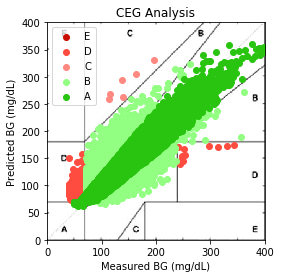

In [114]:
percents = CEG_analysis(test_y,pred_y)

In [111]:
percents

[76.2905372277089,
 17.23751488407929,
 0.04202563563773902,
 6.4299222525740705,
 0.0]

In [112]:
print(percents[0]+percents[1],'% of predictions in safe regions A and B')

93.52805211178818 % of predictions in safe regions A and B


In [90]:
np.sum(percents)

100.0

In [134]:
y_t0 = train_x.copy()
y_t0.loc[:,:] = scaler.inverse_transform(train_x)
y_t0 = y_t0['BG0']

In [135]:
get_RMSE(train_y,y_t0)

25.25287516148635

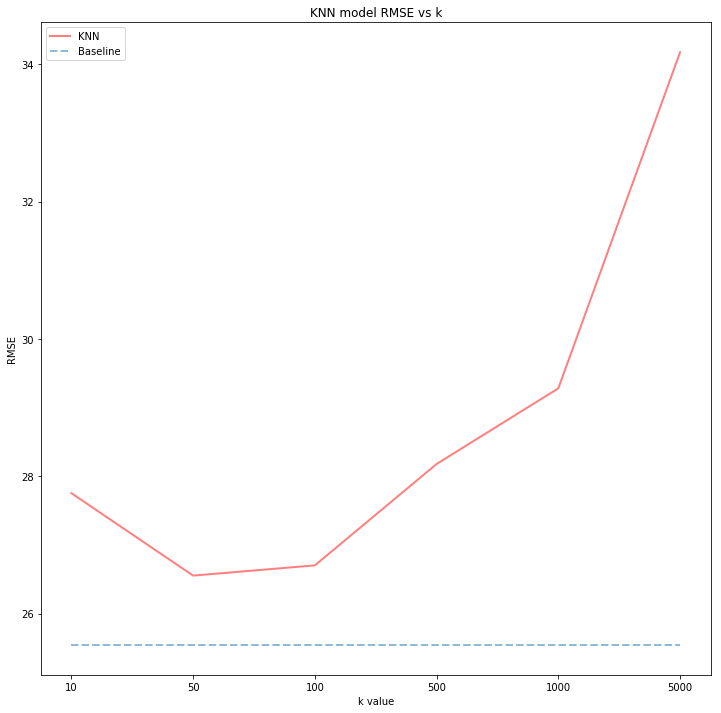

In [146]:
plt.figure(figsize=[12,12])
plt.plot([27.754, 26.553, 26.702, 28.179, 29.281, 34.1780], 'r', lw=2, alpha=.5)
plt.plot([25.54 for _ in range(6)], '--', lw=2, alpha=.5)
plt.xticks([0,1,2,3,4,5], [10,50,100,500,1000,5000])
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.title('KNN model RMSE vs k')
plt.legend(['KNN', 'Baseline'])
